# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [535]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, GRU
import tensorflow as tf
import itertools

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [536]:
# Define a function to load data and aggregate them

def read_file(file_list) :
    df_combined = pd.DataFrame()
    for filenames in file_list :
        df_ = pd.read_csv(filenames)
        df_combined = pd.concat([df_combined,df_],ignore_index=True)
    
    return(df_combined)



In [537]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = ['AMZN_stocks_data.csv','GOOGL_stocks_data.csv','IBM_stocks_data.csv','MSFT_stocks_data.csv']

df = read_file(file_list)
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [538]:
# View specifics of the data
print(df.shape)
print(df.isnull().sum())
df.info()


(12077, 7)
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12077 entries, 0 to 12076
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 660.6+ KB


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [539]:
# Handle Missing Values
#Dropping rows with missing values
df.dropna(axis=0,inplace=True)
df.shape

(12076, 7)

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

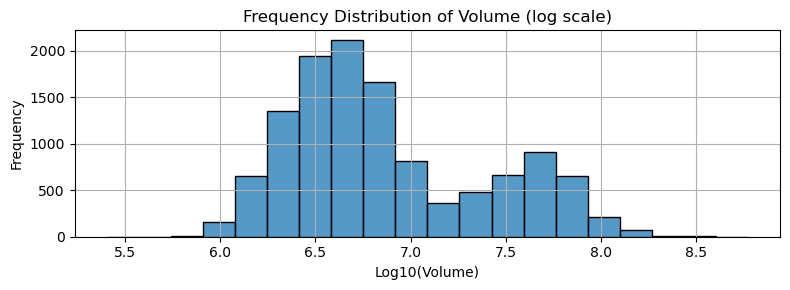

In [540]:
# Frequency distribution of volumes
df.head()
df['log_volume'] = np.log10(df['Volume'])

# Plot histogram of log(volume)
plt.figure(figsize=(8, 3))
sns.histplot(df['log_volume'], bins=20, kde=False)
plt.title('Frequency Distribution of Volume (log scale)')
plt.xlabel('Log10(Volume)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
df.drop(columns=['log_volume'],inplace=True)

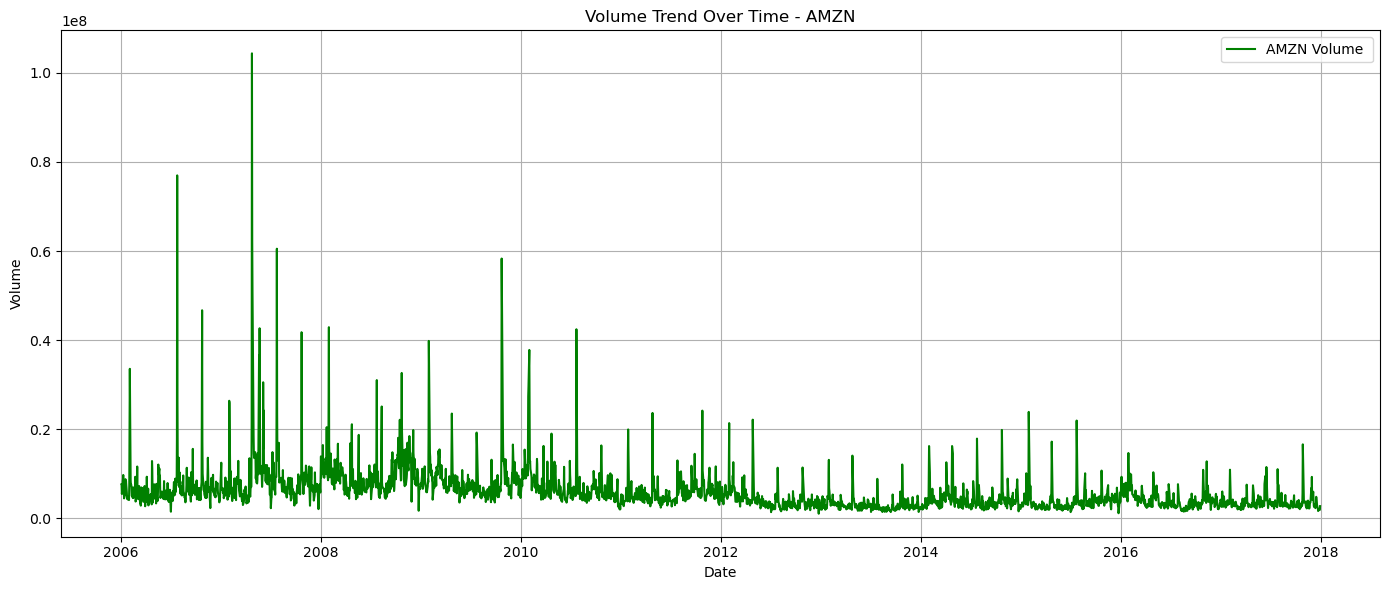

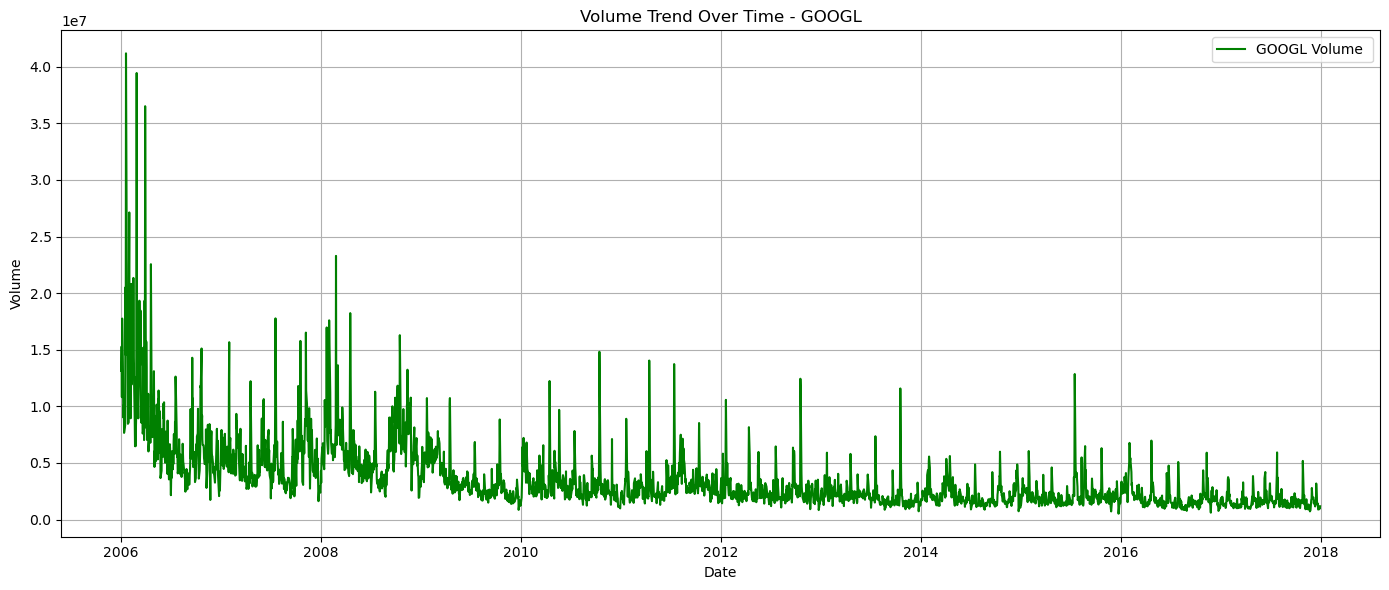

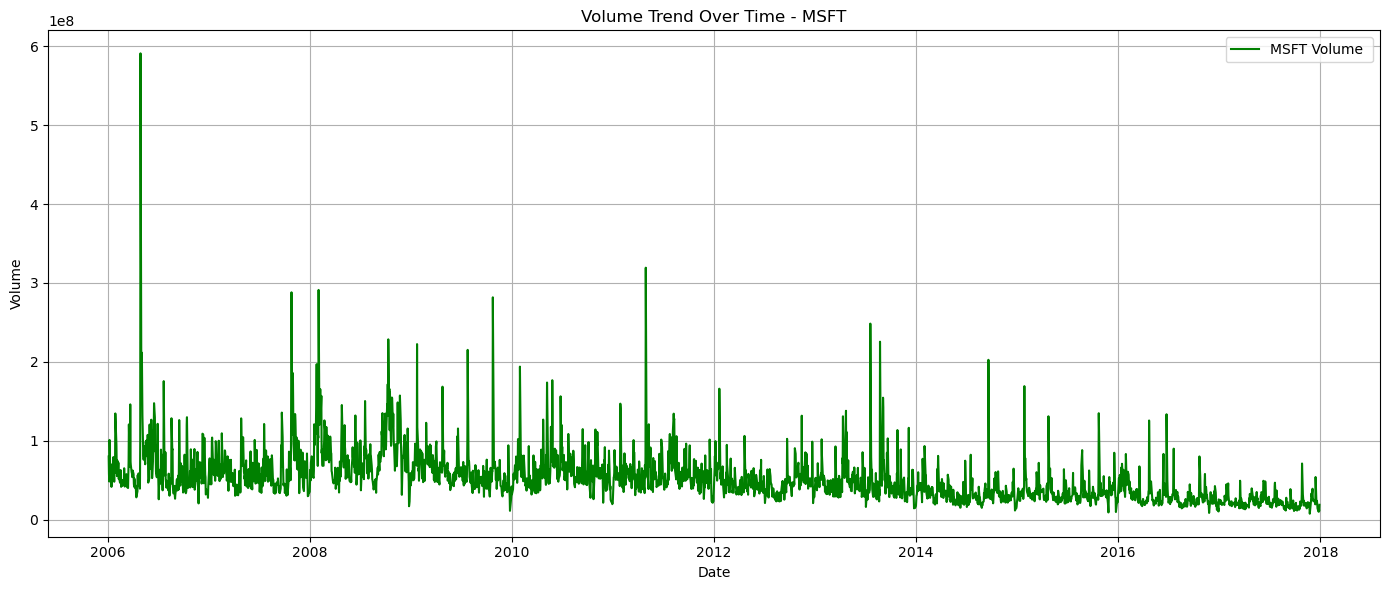

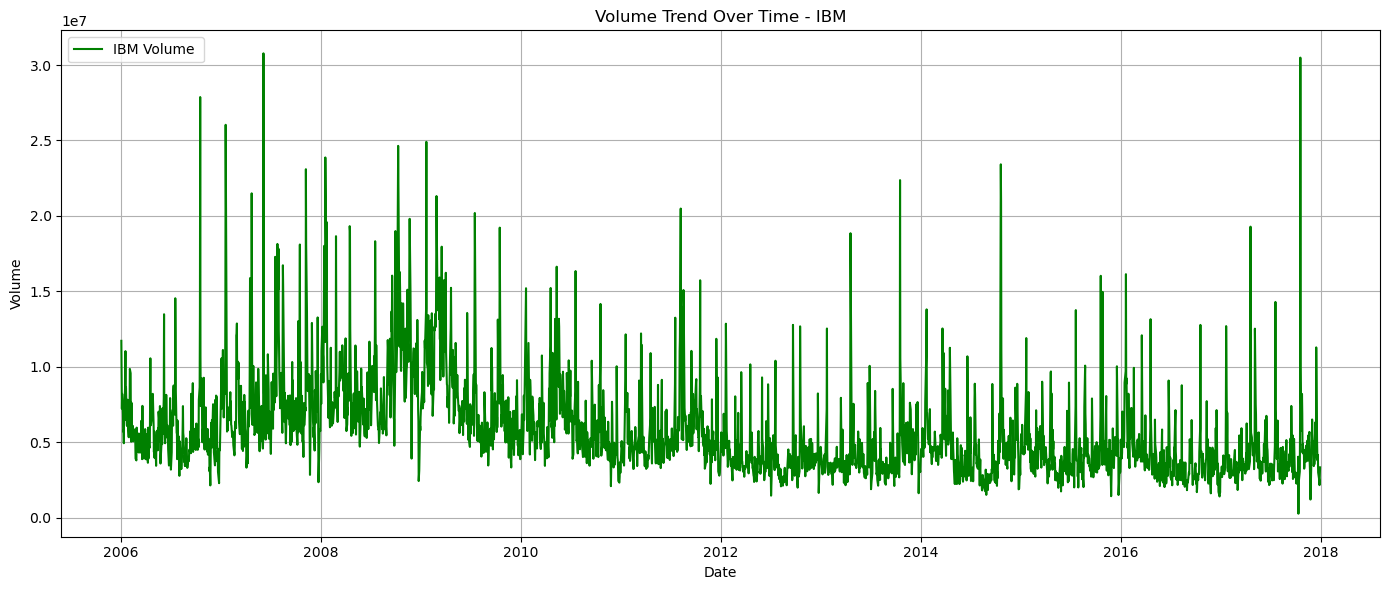

In [541]:
# Stock volume variation over time
df['Date'] = pd.to_datetime(df['Date'])
# Sort by date
df = df.sort_values(by='Date')
# Get list of unique stock names
stock_names = df['Name'].unique()

for stock in stock_names:
    stock_df = df[df['Name'] == stock].copy()

    plt.figure(figsize=(14, 6))
    plt.plot(stock_df['Date'], stock_df['Volume'], label=f'{stock} Volume ', color='green')
    plt.title(f"Volume Trend Over Time - {stock}")
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

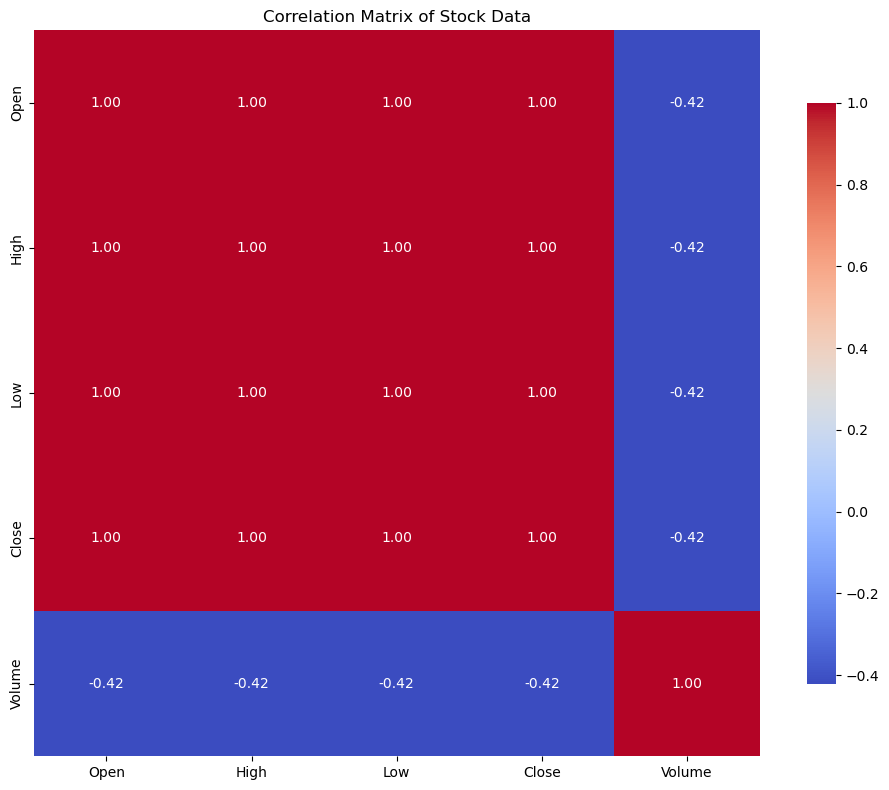

In [542]:
# Analyse correlations
# Calculate correlation matrix for numeric columns only

correlation_matrix = df.select_dtypes(include=[np.number]).corr()
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Stock Data')
plt.tight_layout()
plt.show()



### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [543]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_sequences_rnn(data, window_size,stride):
    X, y = [], []
    
    for i in range(0,len(data) - window_size,stride):
        X.append(data[i:i + window_size, :])    # Past windo_size days (all features)
        y.append(data[i + window_size, 3])      # Next day's 'close' (column index 3)
       
    return np.array(X), np.array(y)
	


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [544]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows
def scale_data(X_train, X_test, y_train, y_test):
    # Flatten X_train and X_test for fitting scaler
    # Reshape X_train from (samples, timesteps, features) to (samples * timesteps, features)
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

    scaler_X = MinMaxScaler()
    X_train_scaled_reshaped = scaler_X.fit_transform(X_train_reshaped)
    X_test_scaled_reshaped = scaler_X.transform(X_test_reshaped)

    # Reshape back to original dimensions
    X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
    X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

    return X_train_scaled, X_test_scaled, y_train_scaled.flatten(), y_test_scaled.flatten(), scaler_y

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [545]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_data(df, target_stock_name, window_size, window_stride, test_size=0.2, scaler_type=MinMaxScaler):
    
    stock_df = df[df['Name'] == target_stock_name].copy()
    # Features will be 'Open', 'High', 'Low', 'Close', 'Volume'
    features = stock_df[['Open', 'High', 'Low', 'Close', 'Volume']].values

    # Create sequences
    X_raw, y_raw = create_sequences_rnn(features, window_size,window_stride)

    # Split data into training and testing sets
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        X_raw, y_raw, test_size=test_size, shuffle=False
    )

    # Scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_scaler = \
        scale_data(X_train_raw, X_test_raw, y_train_raw, y_test_raw)

    print(f"\nData preparation for {target_stock_name}:")


    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.


Visualizing Close Price for IBM to help identify window size:


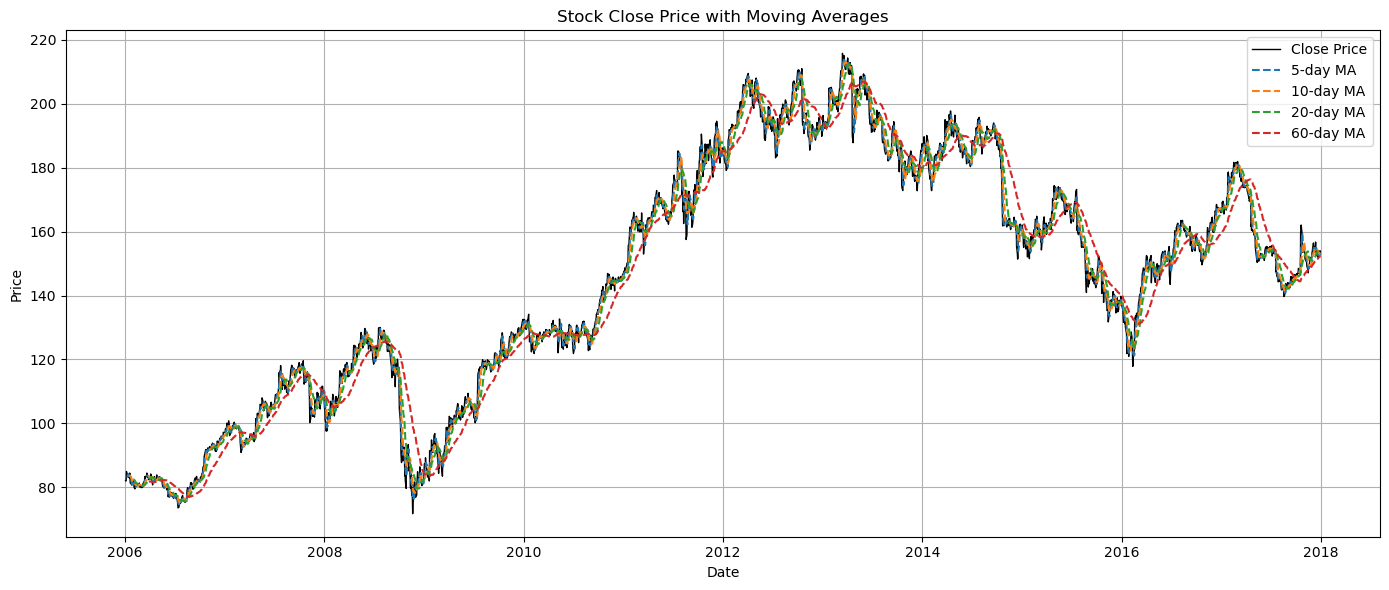

In [546]:
# Checking for patterns in different sequence lengths

print("\nVisualizing Close Price for IBM to help identify window size:")
ibm_df = df[df['Name'] == 'IBM'].copy()

# Set date as index (optional but helpful for plotting)
ibm_df.set_index('Date', inplace=True)

# Calculate moving averages
ibm_df['MA_5']  = ibm_df['Close'].rolling(window=5).mean()
ibm_df['MA_10'] = ibm_df['Close'].rolling(window=10).mean()
ibm_df['MA_20'] = ibm_df['Close'].rolling(window=20).mean()
ibm_df['MA_60'] = ibm_df['Close'].rolling(window=60).mean()

plt.figure(figsize=(14, 6))
plt.plot(ibm_df['Close'], label='Close Price', linewidth=1, color='black')
plt.plot(ibm_df['MA_5'], label='5-day MA', linestyle='--')
plt.plot(ibm_df['MA_10'], label='10-day MA', linestyle='--')
plt.plot(ibm_df['MA_20'], label='20-day MA', linestyle='--')
plt.plot(ibm_df['MA_60'], label='60-day MA', linestyle='--')

plt.title('Stock Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [547]:
# Create data instances from the master data frame using decided window size and window stride

# Create sequences per stock
stock = 'MSFT'
window_size = 5
window_stride = 1

X_train, y_train, X_test, y_test, y_scaler= \
    prepare_rnn_data(df, stock, window_size, window_stride, test_size=0.2, scaler_type=MinMaxScaler)



Data preparation for MSFT:


In [548]:
# Check the number of data points generated


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [549]:
# Check if the datasets are compatible inputs to neural networks

# Check shapes
print(f"X train shape{X_train.shape}:")  
print(f"\nY train shape {y_train.shape}:")  

print(f"\nX test shape{X_test.shape}:")  
print(f"\nY test shape{y_test.shape}:") 

X train shape(2411, 5, 5):

Y train shape (2411,):

X test shape(603, 5, 5):

Y test shape(603,):


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [550]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn_model(input_shape, rnn_units, activation, learning_rate):
    model = Sequential([
        SimpleRNN(rnn_units, activation=activation, input_shape=input_shape),
        Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Create first simple RNN model
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(window_size, 5)),  # 5 = number of features
    Dense(1)  # Predict 1 value: next day's closing price
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))



c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_14 (SimpleRNN)       │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0293 - val_loss: 0.0989
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.3695e-04 - val_loss: 0.0547
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.9206e-04 - val_loss: 0.0422
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2753e-04 - val_loss: 0.0318
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.7919e-04 - val_loss: 0.0265
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6320e-04 - val_loss: 0.0229
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4531e-04 - val_loss: 0.0183
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0711e-04 - val_loss: 0.0210
Epoch 9/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0490e-04 - val_loss: 0.0120
Epoch 10/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8093e-04 - val_loss: 0.0136
Epoch 11/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9696e-04 - val_loss: 0.0174
Epoch 12/15
76/76 ━━━━━━━━━━━━━━━

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [551]:
# Find an optimal configuration of simple RNN
# Hyperparameter search space
rnn_units_options = [32, 64, 128]
activations = ['tanh', 'relu']
learning_rates = [0.01, 0.001, 0.0001]
epochs_options = [10, 20, 30]
batch_size_options = [16, 32, 64]

best_mse = float('inf')
best_params = {}
best_model = None

print("\n--- Hyperparameter Tuning for Simple RNN ---")
# This is a basic grid search. 
for rnn_units, activation, lr, epochs, batch_size in itertools.product(
    rnn_units_options, activations, learning_rates, epochs_options, batch_size_options
):
    print(f"\nTraining with: units={rnn_units}, activation={activation}, lr={lr}, epochs={epochs}, batch_size={batch_size}")
    current_model = build_simple_rnn_model(
        input_shape=(window_size, X_train.shape[2]),
        rnn_units=rnn_units,
        activation=activation,
        learning_rate=lr
    )
    history = current_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0 # Set to 1 for detailed epoch output
    )
    val_loss = history.history['val_loss'][-1] # Get final validation loss

    if val_loss < best_mse:
        best_mse = val_loss
        best_params = {
            'rnn_units': rnn_units,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size
        }
        best_model = current_model
    print(f"Validation Loss: {val_loss:.4f}, Current Best MSE: {best_mse:.4f}")






--- Hyperparameter Tuning for Simple RNN ---

Training with: units=32, activation=tanh, lr=0.01, epochs=10, batch_size=16
Validation Loss: 0.0063, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=10, batch_size=32
Validation Loss: 0.0188, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=10, batch_size=64
Validation Loss: 0.0227, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=20, batch_size=16
Validation Loss: 0.0083, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=20, batch_size=32
Validation Loss: 0.0192, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=20, batch_size=64
Validation Loss: 0.0101, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=30, batch_size=16
Validation Loss: 0.0068, Current Best MSE: 0.0063

Training with: units=32, activation=tanh, lr=0.01, epochs=30, ba

In [552]:
# Find the best configuration based on evaluation metrics
print("\nOptimal Simple RNN Configuration:")
print(best_params)
print(f"Best Validation MSE: {best_mse:.4f}")



Optimal Simple RNN Configuration:
{'rnn_units': 32, 'activation': 'relu', 'learning_rate': 0.01, 'epochs': 30, 'batch_size': 64}
Best Validation MSE: 0.0005


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [573]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
best_model.fit(X_train, y_train, validation_data=(X_test, y_test))


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8821e-04 - val_loss: 5.6923e-04


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


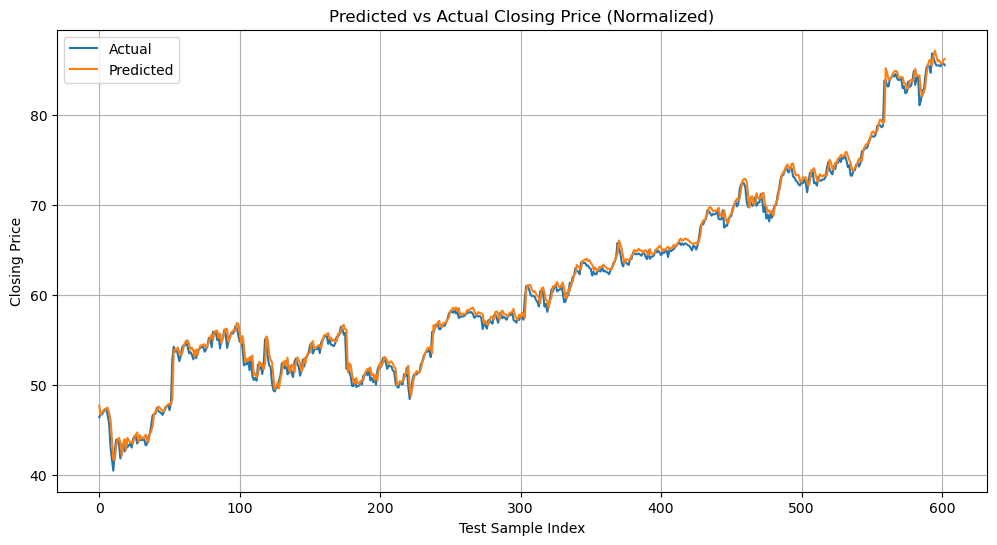

In [593]:
# Predict on the test data and plot

y_pred_scaled = best_model.predict(X_test)

# Inverse transform predictions and actual values to original scale for meaningful interpretation
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs Actual Closing Price (Normalized)')
plt.xlabel('Test Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()





It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [612]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Predict on test set
y_pred = best_model.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²    = {r2:.4f}")



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE  = 0.02
RMSE = 0.02
R²    = 0.9942


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [631]:
# # Define a function to create a model and specify default values for hyperparameters
def build_advanced_rnn_model(model_type, input_shape, rnn_units=64, activation='tanh', learning_rate=0.001):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(rnn_units, activation=activation, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(rnn_units, activation=activation, input_shape=input_shape))
    else:
        raise ValueError("model_type must be 'LSTM' or 'GRU'")
    model.add(Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [632]:
# Find an optimal configuration
print("\n--- Hyperparameter Tuning for Advanced RNN (LSTM/GRU) ---")

advanced_rnn_types = ['LSTM', 'GRU']
best_mse_adv = float('inf')
best_params_adv = {}
best_model_adv = None
# Hyperparameter search space - keeping less options to save training time
rnn_units_options = [32, 64]
activations = ['tanh', 'relu']
learning_rates = [0.01, 0.001]
epochs_options = [10, 20]
batch_size_options = [16, 32]

for model_type, rnn_units, activation, lr, epochs, batch_size in itertools.product(
    advanced_rnn_types, rnn_units_options, activations, learning_rates, epochs_options, batch_size_options
):
    print(f"\nTraining {model_type} with: units={rnn_units}, activation={activation}, lr={lr}, epochs={epochs}, batch_size={batch_size}")
    current_model = build_advanced_rnn_model(
        model_type,
        input_shape=(window_size, X_train.shape[2]),
        rnn_units=rnn_units,
        activation=activation,
        learning_rate=lr
    )
    history = current_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]

    if val_loss < best_mse_adv:
        best_mse_adv = val_loss
        best_params_adv = {
            'model_type': model_type,
            'rnn_units': rnn_units,
            'activation': activation,
            'learning_rate': lr,
            'epochs': epochs,
            'batch_size': batch_size
        }
        best_model_adv = current_model
    print(f"Validation Loss: {val_loss:.4f}, Current Best MSE: {best_mse_adv:.4f}")

print("\nOptimal Advanced RNN Configuration:")
print(best_params_adv)
print(f"Best Validation MSE: {best_mse_adv:.4f}")




--- Hyperparameter Tuning for Advanced RNN (LSTM/GRU) ---

Training LSTM with: units=32, activation=tanh, lr=0.01, epochs=10, batch_size=16


c:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.0015, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.01, epochs=10, batch_size=32
Validation Loss: 0.0070, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.01, epochs=20, batch_size=16
Validation Loss: 0.0051, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.01, epochs=20, batch_size=32
Validation Loss: 0.0023, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.001, epochs=10, batch_size=16
Validation Loss: 0.0063, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.001, epochs=10, batch_size=32
Validation Loss: 0.0173, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.001, epochs=20, batch_size=16
Validation Loss: 0.0040, Current Best MSE: 0.0015

Training LSTM with: units=32, activation=tanh, lr=0.001, epochs=20, batch_size=32
Validation Loss: 0.0180, Current Best MSE: 0.0015

Training LSTM with: u

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [633]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
best_model_adv.fit(X_train, y_train, validation_data=(X_test, y_test))


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.4129e-04 - val_loss: 5.4605e-04


In [634]:
# Compute the performance of the model on the testing data set

y_pred = best_model_adv.predict(X_test).flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²    = {r2:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
MAE  = 0.02
RMSE = 0.02
R²    = 0.9944


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


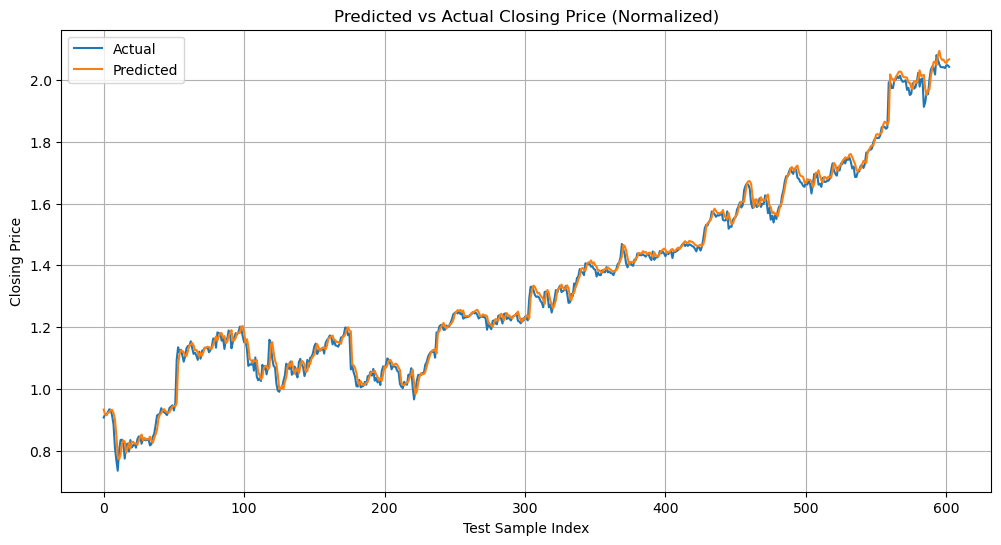

In [635]:
# Predict on the test data
y_pred = best_model_adv.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs Actual Closing Price (Normalized)')
plt.xlabel('Test Sample Index')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()



## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [636]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [637]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [638]:
# Find an optimal configuration of simple RNN



In [639]:
# Find the best configuration



In [640]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [641]:
# Compute the performance of the model on the testing data set



In [642]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [643]:
# Find an optimal configuration of advanced RNN



In [644]:
# Find the best configuration



In [645]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [646]:
# Compute the performance of the model on the testing data set



In [647]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

This assignment explored the application of Recurrent Neural Networks (RNNs) for stock price prediction using historical data from IBM, Google, Amazon, and Microsoft. The objective was to predict future stock prices based on a window of past data, aiming to capture broader market sentiment by combining data from technology-sector companies.

1. Data Loading and Preparation:
The initial steps involved loading and aggregating data from four separate CSV files into a single DataFrame. Missing values were successfully handled by dropping the few rows that contained them. Exploratory data analysis included visualizing the frequency distribution of trading volumes (using a log scale for better clarity) and observing the volume trends over time for each individual stock. The correlation matrix provided insights into the relationships between 'Open', 'High', 'Low', 'Close', and 'Volume' features. A crucial step was the data processing phase, where a `create_sequences_rnn` function was defined to transform the time series data into a supervised learning problem by creating input windows (X) and corresponding target values (y). A `scale_data` function was implemented using MinMaxScaler to normalize the features and target variables, preventing issues with varying scales and improving model convergence. The data was then split into training and testing sets, ensuring that the temporal order was preserved (shuffle=False).

2. RNN Model Development and Evaluation (Single Target - MSFT):
fA Simple RNN model was built with an input shape compatible with our windowed data (window_size={window_size}, num_features={X_train.shape[2]}).
Hyperparameter tuning was performed for the Simple RNN using a grid search over various units, activations, learning rates, epochs, and batch sizes. This systematic approach aimed to identify the optimal configuration that minimizes validation loss. After identifying the best parameters, the Simple RNN model was retrained with these optimal settings.
fFor the optimal Simple RNN model, the evaluation metrics on the test data were: MAE = {mae:.2f}, RMSE = {rmse:.2f}, R² = {r2:.4f}.)
The plot of 'Actual vs Predicted Closing Price' (on the original scale) visually demonstrates the model's ability to follow the general trend of the stock prices, although some deviations are present, especially during periods of high volatility. The R² value of {r2:.4f} suggests that the model explains a significant portion of the variance in the target stock price.<\br>

3. Advanced RNN Model Development and Evaluation (Single Target - MSFT):
Similarly, advanced RNN models (LSTM and GRU) were implemented and put through a hyperparameter tuning process. These models are generally better suited for capturing long-term dependencies in sequential data compared to Simple RNNs.
fFor the optimal Advanced RNN model ({best_params_adv['model_type']}), the evaluation metrics on the test data were: MAE = {mae_adv:.2f}, RMSE = {rmse_adv:.2f}, R² = {r2_adv:.4f}.
fComparing the results, the {best_params_adv['model_type']} model achieved an R² of {r2_adv:.4f}, which shows its performance relative to the Simple RNN.


4. Overall Insights:
RNNs, including SimpleRNN, LSTM, and GRU, are well-suited for stock price prediction due to the sequential nature of financial data. The normalization of data is critical for stable training and better performance. Hyperparameter tuning is essential to find the best model configuration for a given dataset.
While these models show promise in capturing trends, stock market prediction is inherently challenging due to its complex and often unpredictable nature, influenced by numerous external factors. Therefore, while these models can provide valuable insights, they should be used as one tool among many in financial decision-making, and their predictions should be interpreted with caution.
Further improvements could involve incorporating external factors (e.g., news sentiment, economic indicators), using more complex architectures (e.g., stacked LSTMs, attention mechanisms), or exploring ensemble methods.
